# Example of an extended maximum likelihood fit (signal + background fit)

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit

In [102]:
# array of data points x_i
# x_i = np.load('data/dimuon.npy')[0:10000]
x_i = np.load('data/dimuon.npy')[0:150]
m_min, m_max = 2.5, 3.75
x_i = x_i[(x_i > m_min) & (x_i < m_max)]

In [103]:
# normalized pdf 
def f(m, m_min, m_max, bckgr_intercept, bckgr_slope, mean, sigma, r):

    # linear background 
    norm_bckgr = bckgr_intercept * (m_max - m_min) + 0.5 * bckgr_slope * (m_max**2 - m_min**2)
    bckgr = (bckgr_intercept + bckgr_slope * m) / norm_bckgr
    
    # signal (Gaussian)
    signal = 1./(2.*np.pi)**0.5/sigma * np.exp(-0.5*((m-mean)/sigma)**2)
   
    # r = signal fraction
    return r * signal + (1. - r) * bckgr

We need to minimize:

$$- \ln \tilde L(\vec \theta) =  s+b - n \ln(s+b) - \sum_{i=1}^n \ln[f(x_i; \vec \theta)]$$ 

In [104]:
def negative_log_likelihood(s, b, bckgr_intercept, bckgr_slope, mean, sigma):
    n = x_i.size
    r = s / (s + b)
    lnf = np.log(f(x_i, m_min, m_max, bckgr_intercept, bckgr_slope, mean, sigma, r))
    return s + b - n * np.log(s + b) - np.sum(lnf)

In [105]:
# Minuit object, chose useful starting values and parameters limits
m = Minuit(negative_log_likelihood, 
           s=0.3*x_i.size, b=0.7*x_i.size, bckgr_intercept=200., bckgr_slope=-40, 
           mean=3.1, sigma=0.03,
           limit_s=(0.,x_i.size), limit_b=(0.,x_i.size), limit_bckgr_intercept=(160,1000.), 
           limit_bckgr_slope=(-42, -30), limit_sigma=(0.,0.5),
           errordef=Minuit.LIKELIHOOD)

In [106]:
m.migrad()

------------------------------------------------------------------
| FCN = -428.2                  |     Ncalls=139 (139 total)     |
| EDM = 7.85e-06 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------
|   | Name            |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-----------------------------------------------------------------------------------------------------
| 0 | s               |    33     |     7     |            |            |    0    |   113   |       |
| 1 | b               |    80     |    10     |            |            |    0    |   113   |       |
| 2 | bckgr_intercept |  0.18e3   |  0.10e3   |            |            |   160   |  1000   |       |
| 3 | bckgr_slope     |    -41    |    10     |            |            |   -42   |   -30   |       |
| 4 | mean            |   3.094   |   0.008   |            |            |         |         |       |
| 5 | sigma           |   0.035   |   0.008   |            |            |    0    |   0.5   |       |
-----------------------------------------------------------------------------------------------------

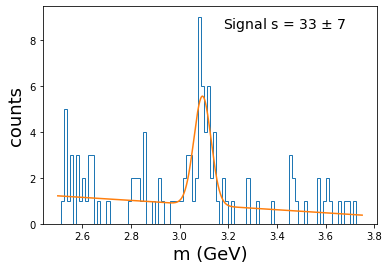

In [107]:
# fit parameters
s, s_err, b = m.values['s'], m.errors['s'], m.values['b']
bckgr_intercept, bckgr_slope = m.values['bckgr_intercept'], m.values['bckgr_slope']
mean, sigma = m.values['mean'], m.values['sigma']
r = s / (s + b)

# get prediction for best fit parameters
mass = np.linspace(m_min, m_max, 1000)
fit = f(mass, m_min, m_max, bckgr_intercept, bckgr_slope, mean, sigma, r)

# plot data and fit function
nbins = 100
binwidth = (m_max - m_min)/nbins
fig, ax = plt.subplots()
plt.hist(x_i, bins=nbins, range=(m_min,m_max), histtype='step');
plt.plot(mass, (s+b) * binwidth * fit)
plt.xlabel("m (GeV)", fontsize=18)
plt.ylabel("counts", fontsize=18);
txt = r'Signal s = {:.0f} $\pm$ {:.0f}'.format(s, s_err)
plt.text(0.54, 0.9, txt, fontsize=14, transform=ax.transAxes);
# plt.savefig("ext_ml_fit_2.pdf")